In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from Algorithms.Agents.DQN import DQN
from Algorithms.common.replay_buffers import ReplayBuffer
from torch.optim import Adam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class DQNAgent:
    
    def __init__(self, _env: gym.envs, use_conv=True, _lr=3e-4, _gamma=0.99, _buffer_size=10000):
        self.env = _env
        self.lr = _lr
        self.gamma = _gamma
        self.epsilon = 1
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.replay_buffer = ReplayBuffer(_buffer_size)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.use_conv = use_conv
        # todo change name to net
        self.model = DQN(_env.observation_space.shape, _env.action_space.n, use_conv=use_conv).to(self.device) 
        self.optimizer = Adam(self.model.parameters())
        self.MSE_loss = nn.MSELoss()
    
    def get_action(self, _state: torch.tensor):   # what is the type of state?
        _state = _state.unsqueeze(0).to(self.device)
        qvals = self.model(_state)
        _action = torch.argmax(qvals).item()
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

        return self.env.action_space.sample() if random.random() < self.epsilon else _action
    
    def compute_loss(self, _batch):
        states, actions, rewards, next_states, terms, truncs = zip(*_batch)
        states = torch.stack(states).to(self.device)
        actions = torch.tensor(actions).to(self.device)
        rewards = torch.tensor(rewards).to(self.device)
        next_states = torch.stack(next_states).to(self.device)
        dones = torch.tensor([terms[i] or truncs[i] for i in range(len(terms))]).float().to(self.device)
        
        Q_expected = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # (B)
        Q_target_next = self.model(next_states).detach().max(1)[0]   # (B, A) 
        Q_target = rewards + self.gamma * Q_target_next * (1 - dones)
        
        loss = self.MSE_loss(Q_expected, Q_target)
        return loss
    
    def update(self, _batch_size):
        batch = self.replay_buffer.sample(_batch_size)
        loss = self.compute_loss(batch)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

$$ L = \left( R_t + \gamma^n \max_{a'} Q(S_{t+1}, a') - Q(S_t, A_t) \right)^2 $$

/home/kostiskak/anaconda3/envs/ai_env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Episode 0: 38.0
Episode 1: 12.0
Episode 2: 11.0
Episode 3: 40.0
Episode 4: 13.0
Episode 5: 10.0
Episode 6: 17.0
Episode 7: 19.0
Episode 8: 14.0
Episode 9: 11.0
Episode 10: 31.0
Episode 11: 51.0
Episode 12: 46.0
Episode 13: 23.0
Episode 14: 19.0
Episode 15: 31.0
Episode 16: 37.0
Episode 17: 38.0
Episode 18: 38.0
Episode 19: 89.0
Episode 20: 88.0
Episode 21: 86.0
Episode 22: 241.0
Episode 23: 197.0
Episode 24: 216.0
Episode 25: 150.0
Episode 26: 207.0
Episode 27: 437.0
Episode 28: 13.0
Episode 29: 11.0
Episode 30: 11.0
Episode 31: 10.0
Episode 32: 9.0
Episode 33: 10.0
Episode 34: 9.0
Episode 35: 10.0
Episode 36: 9.0
Episode 37: 10.0
Episode 38: 9.0
Episode 39: 58.0
Episode 40: 30.0
Episode 41: 13.0
Episode 42: 16.0
Episode 43: 20.0
Episode 44: 18.0
Episode 45: 82.0
Episode 46: 260.0
Episode 47: 249.0
Episode 48: 195.0
Episode 49: 152.0
Episode 50: 155.0
Episode 51: 138.0
Episode 52: 203.0
Episode 53: 182.0
Episode 54: 121.0
Episode 55: 103.0
Episode 56: 184.0
Episode 57: 316.0
Episode 58

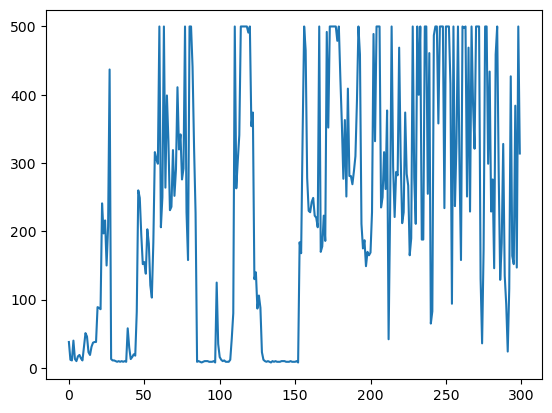

In [3]:
env = gym.make('CartPole-v1')

episode_reward = 0
batch_size = 32
max_episodes = 300
max_steps = 1000
    
# Initialize your DQN model
agent = DQNAgent(env, use_conv=False)

episode_rewards = []

for episode in range(max_episodes):
    episode_reward = 0
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).to(device)
    
    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc)
                                 
        episode_reward += reward
        
        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)
            
        if term or trunc:
            episode_rewards.append(episode_reward)
            print(f"Episode {episode}: {episode_reward}")
            break
    
        state = next_state
    
plt.plot(episode_rewards)
# # Test the model with a few steps in the environment
# for i in range(10):
#     action = agent.get_action(state)
#     state, reward, term, trunc, _ = env.step(action)
#     if term or trunc: break

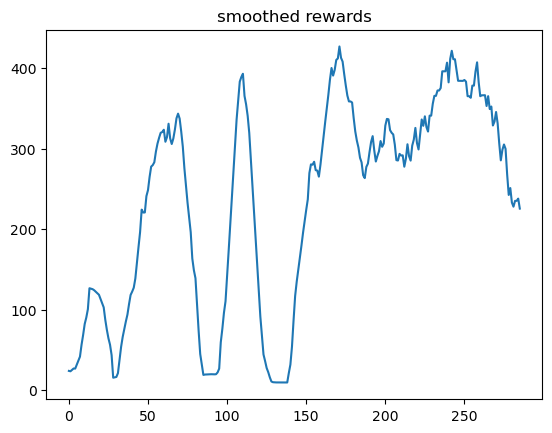

In [4]:
# Smoothed: 
def moving_average(data, _window_size):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[_window_size:] - cumsum_vec[:-_window_size]) / _window_size
window_size = 15
smoothed_rew = moving_average(episode_rewards, window_size)
plt.plot(smoothed_rew)
plt.title('smoothed rewards')
plt.show()
# todo check why does it fall

# Atari test (unfinished)

In [ ]:
# # Hyperparameters
# batch_size = 64
# lr = 1e-3
# gamma = 0.99
# epsilon = 1.0
# epsilon_decay = 0.996
# min_epsilon = 0.01
# buffer_capacity = 10000
# num_episodes = 10000
# 
# 
# def env_creator(env_id, is_atari=True):
#     env_ = gym.make(env_id)
#     if is_atari:
#         from gymnasium.wrappers import GrayScaleObservation, FrameStack, TransformReward
#         from gymnasium.wrappers.atari_preprocessing import AtariPreprocessing
# 
#         # Create an Atari environment with preprocessing wrappers
#         env_ = gym.make(env_id)
#         env_ = AtariPreprocessing(env_, frame_skip=4, screen_size=84, scale_obs=True)
#         env_ = FrameStack(env_, num_stack=4)
#         env_ = TransformReward(env_, lambda r: np.clip(r, -1, 1))
#     return env_
# 
# # Setup
# env = env_creator('BreakoutNoFrameskip-v4')
# action_size = env.action_space.n
# observation_shape = env.observation_space.shape
# model = DQN(observation_shape, action_size).to(device)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# replay_buffer = ReplayBuffer(buffer_capacity)
# 
# # Training Loop
# for episode in tqdm(range(num_episodes), desc='Training Progress'):
#     state = env.reset()
#     state = torch.FloatTensor(state[0]).to(device)
#     episode_reward = 0
#     episode_losses = []
#     episode_q_values = []
# 
#     while True:
#         # Epsilon-greedy policy
#         if random.random() < epsilon:
#             action = env.action_space.sample()
#         else:
#             with torch.no_grad():
#                 q_values = model(state.unsqueeze(0))  # [1, 4, 84,84]
#                 episode_q_values.append(q_values.max().item())
#             _, action = torch.max(q_values, 1)  # action = max_action idx not the value
#             action = action.item()
# 
#         # Take action and observe the next state and reward
#         next_state, reward, term, trunc, _ = env.step(action)
#         next_state = torch.FloatTensor(next_state).to(device)
# 
#         # Store in replay buffer
#         replay_buffer.push(state, action, reward, next_state, term, trunc)
# 
#         state = next_state
#         episode_reward += reward
# 
#         if term or trunc:
#             break
# 
#         # Learn
#         if len(replay_buffer) > batch_size:
#             batch = replay_buffer.sample(batch_size)
#             batch_states, batch_actions, batch_rewards, batch_next_states, batch_terms, batch_truncs = zip(*batch)
#             batch_dones = [term or trunc for term, trunc in zip(batch_terms, batch_truncs)]
# 
#             batch_states = torch.stack(batch_states)  # [64,4,84,84]
#             batch_actions = torch.LongTensor(batch_actions)
#             batch_rewards = torch.FloatTensor(batch_rewards)
#             batch_next_states = torch.stack(batch_next_states)
#             batch_dones = torch.FloatTensor(batch_dones)
# 
#             # Compute the current Q values
#             current_q_values = model(batch_states).gather(1, batch_actions.unsqueeze(1)).squeeze(1)
# 
#             # Compute the next Q values using target network
#             next_q_values = model(batch_next_states).max(1)[0].detach()
#             expected_q_values = batch_rewards + gamma * next_q_values * (1 - batch_dones)
# 
#             # Loss
#             loss = nn.MSELoss()(current_q_values, expected_q_values)
#             episode_losses.append(loss.item())
# 
#             # Gradient descent
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
# 
#     # Update epsilon
#     epsilon = max(min_epsilon, epsilon_decay * epsilon)
# 
#     # Print average loss and average max Q-value
#     avg_loss = sum(episode_losses) / len(episode_losses) if episode_losses else float('nan')
#     avg_max_q_value = sum(episode_q_values) / len(episode_q_values) if episode_q_values else float('nan')
# 
#     if episode % 100 == 0:
#         tqdm.write(f'Episode: {episode}, Total Reward: {episode_reward}, Average Loss: {avg_loss:.4f}, Average Max Q-Value: {avg_max_q_value:.4f}')
# 
# 
# env.close()
